In [53]:
!pip install mip geopandas contextily

In [54]:
from math import radians, sin, cos, sqrt, atan2
from collections import namedtuple
import random
import mip
import matplotlib.pyplot as plt

from collections import namedtuple
import math


Location = namedtuple("Location", ["latitude", "longitude"])
Customer = namedtuple("Customer", ["index", "name", "location", "demand", "time_window"])


neighborhood_data = {
    "Chapinero": (4.6451, -74.0616), "Usaquén": (4.6950, -74.0312),
    "Suba": (4.7410, -74.0825), "Engativá": (4.7071, -74.1072),
    "Fontibón": (4.6787, -74.1412), "Teusaquillo": (4.6427, -74.0789),
    "La Candelaria": (4.5965, -74.0739), "Kennedy": (4.6292, -74.1498),
    "Ciudad Bolívar": (4.5734, -74.1542), "Bosa": (4.6259, -74.2009)
}

# Función Haversine para calcular distancia entre dos puntos geográficos
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en kilómetros
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])  # Convertir grados en radianes
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distancia en kilómetros


def generate_distance_matrix(customers):
    size = len(customers)
    distance_matrix = [[0]*size for _ in range(size)]
    for i in range(size):
        for j in range(size):
            if i != j:
                lat1 = customers[i].location.latitude
                lon1 = customers[i].location.longitude
                lat2 = customers[j].location.latitude
                lon2 = customers[j].location.longitude
                distance_matrix[i][j] = haversine(lat1, lon1, lat2, lon2)
    return distance_matrix


def generate_customers():
    customers = []
    index = 0
    for name, coords in neighborhood_data.items():
        customers.append(Customer(index=index, name=name, location=Location(*coords), demand=random.randint(4, 10), time_window=(random.randint(360, 900), random.randint(900, 1020))))
        index += 1
    return customers


customers = generate_customers()
distance_matrix = generate_distance_matrix(customers)


total = 0.0
for customer in customers:
    total += customer.demand
    print(f"{customer.index}: {customer.name}, Location: {customer.location}, Demand: {customer.demand}, Time Window: {customer.time_window}")

for row in distance_matrix:
    print(row)
print(total)

0: Chapinero, Location: Location(latitude=4.6451, longitude=-74.0616), Demand: 10, Time Window: (769, 966)
1: Usaquén, Location: Location(latitude=4.695, longitude=-74.0312), Demand: 6, Time Window: (866, 1019)
2: Suba, Location: Location(latitude=4.741, longitude=-74.0825), Demand: 7, Time Window: (894, 949)
3: Engativá, Location: Location(latitude=4.7071, longitude=-74.1072), Demand: 10, Time Window: (736, 991)
4: Fontibón, Location: Location(latitude=4.6787, longitude=-74.1412), Demand: 6, Time Window: (434, 985)
5: Teusaquillo, Location: Location(latitude=4.6427, longitude=-74.0789), Demand: 8, Time Window: (562, 914)
6: La Candelaria, Location: Location(latitude=4.5965, longitude=-74.0739), Demand: 7, Time Window: (508, 1008)
7: Kennedy, Location: Location(latitude=4.6292, longitude=-74.1498), Demand: 8, Time Window: (511, 951)
8: Ciudad Bolívar, Location: Location(latitude=4.5734, longitude=-74.1542), Demand: 5, Time Window: (401, 909)
9: Bosa, Location: Location(latitude=4.6259,

In [55]:
num_customers = len(customers)
num_vehicles = 5
vehicle_capacities = [20,30,30,30,10]

In [56]:
# Crear el modelo
model = mip.Model()
model.verbose = 1  # Habilita la salida detallada
model.max_seconds = 300


# Variables de decisión
x = [[[model.add_var(var_type=mip.BINARY) for j in range(num_customers)] for i in range(num_customers)] for k in range(num_vehicles)]
u = [[model.add_var(var_type=mip.CONTINUOUS, lb=0) for i in range(num_customers)] for k in range(num_vehicles)]
t = [[model.add_var(var_type=mip.CONTINUOUS) for i in range(num_customers)] for k in range(num_vehicles)]

# Función objetivo: Minimizar la distancia total recorrida
model.objective = mip.minimize(
    mip.xsum( distance_matrix[i][j] * x[k][i][j] for k in range(num_vehicles) for i in range(num_customers) for j in range(num_customers))
)

# Restricciones
# 1. Cada cliente es visitado exactamente una vez
for j in range(1, num_customers):
  model += mip.xsum(x[k][i][j] for k in range(num_vehicles) for i in range(num_customers) if i != j) == 1

# 2. Los vehículos salen del depósito y regresan al depósito
for k in range(num_vehicles):
  model += mip.xsum(x[k][0][j] for j in range(1, num_customers)) == 1
  # Sale del depósito
  model += mip.xsum(x[k][i][0] for i in range(1, num_customers)) == 1
  # Regresa al depósito

# 3. Flujo de vehículos: cada cliente al que se llega también se deja
for k in range(num_vehicles):
  for i in range(1, num_customers):
    model += mip.xsum(x[k][i][j] for j in range(num_customers) if i != j) == mip.xsum(x[k][j][i] for j in range(num_customers) if i != j)


for k in range(num_vehicles):
  for i in range(1, num_customers):
    model += mip.xsum( customers[i].demand*x[k][i][j] for j in range(num_customers) if i != j ) <= vehicle_capacities[k]


# 5. Restricción de ventanas de tiempo
for k in range(num_vehicles):
  for i in range(num_customers):
    for j in range(1, num_customers):
      if i != j:
        model += t[k][i] + distance_matrix[i][j] * x[k][i][j] <= t[k][j] + (1 - x[k][i][j])*10000

# 6. Restricción de cumplimiento de ventana de tiempo de cada cliente
for k in range(num_vehicles):
  for i in range(num_customers):
    for j in range(1, num_customers):
      if i != j:
        start_time, end_time = customers[j].time_window
        model += t[k][j] >= start_time * mip.xsum(x[k][i][j] for i in range(num_customers) if i != j)
        model += t[k][j] <= end_time * mip.xsum(x[k][i][j] for i in range(num_customers) if i != j)

In [57]:
# Resolver el modelo
model.optimize()
# Extraer y mostrar las rutas de cada vehículo
vehicle_routes = [[] for _ in range(num_vehicles)]

for k in range(num_vehicles):
  current_location = 0 # Comienza en el depósito

  while True:
    for j in range(num_customers):
      if x[k][current_location][j].x >= 0.99:
        vehicle_routes[k].append((current_location, j))
        current_location = j
        break
    if current_location == 0:
      break # Termina cuando el vehículo regresa al depósito


# Imprimir las rutas en pantalla y graficar
for k, route in enumerate(vehicle_routes):
  print(f"Ruta del vehículo {k + 1} (Capacidad {vehicle_capacities[k]}):")
  route_path = " -> ".join(str(start) for start, end in route)
  print(f"{route_path} -> 0") # Ruta completa de ida y vuelta

Ruta del vehículo 1 (Capacidad 20):
0 -> 1 -> 0
Ruta del vehículo 2 (Capacidad 30):
0 -> 4 -> 7 -> 9 -> 8 -> 0
Ruta del vehículo 3 (Capacidad 30):
0 -> 5 -> 0
Ruta del vehículo 4 (Capacidad 30):
0 -> 6 -> 0
Ruta del vehículo 5 (Capacidad 10):
0 -> 2 -> 3 -> 0


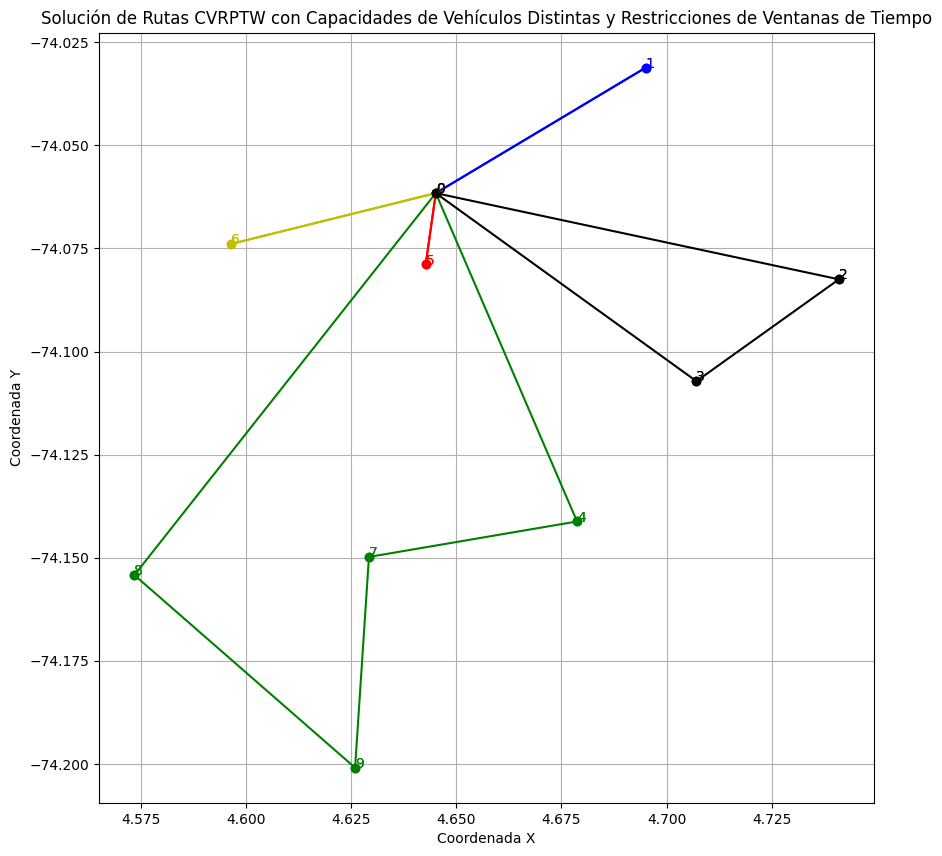

In [58]:
colors = ['b', 'g', 'r', "y", "k"]

# Visualización de las rutas
plt.figure(figsize=(10, 10))

for k, route in enumerate(vehicle_routes):
  for start, end in route:
    plt.plot([customers[start].location.latitude, customers[end].location.latitude],
            [customers[start].location.longitude, customers[end].location.longitude], 'o-', color=colors[k])
    plt.text(customers[start].location.latitude, customers[start].location.longitude, f"{start}", color=colors[k])
    plt.text(customers[end].location.latitude, customers[end].location.longitude, f"{end}", color=colors[k])

plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Solución de Rutas CVRPTW con Capacidades de Vehículos Distintas y Restricciones de Ventanas de Tiempo")
plt.grid()
plt.show()

In [59]:
customers

[Customer(index=0, name='Chapinero', location=Location(latitude=4.6451, longitude=-74.0616), demand=10, time_window=(769, 966)),
 Customer(index=1, name='Usaquén', location=Location(latitude=4.695, longitude=-74.0312), demand=6, time_window=(866, 1019)),
 Customer(index=2, name='Suba', location=Location(latitude=4.741, longitude=-74.0825), demand=7, time_window=(894, 949)),
 Customer(index=3, name='Engativá', location=Location(latitude=4.7071, longitude=-74.1072), demand=10, time_window=(736, 991)),
 Customer(index=4, name='Fontibón', location=Location(latitude=4.6787, longitude=-74.1412), demand=6, time_window=(434, 985)),
 Customer(index=5, name='Teusaquillo', location=Location(latitude=4.6427, longitude=-74.0789), demand=8, time_window=(562, 914)),
 Customer(index=6, name='La Candelaria', location=Location(latitude=4.5965, longitude=-74.0739), demand=7, time_window=(508, 1008)),
 Customer(index=7, name='Kennedy', location=Location(latitude=4.6292, longitude=-74.1498), demand=8, time

In [60]:
data = {}
data['Cliente'] = []
data['Vehiculo'] = []
data['VentanaInicio'] = []
data['VentanaFin'] = []
data['Llegada'] = []

for k in range(num_vehicles):
  for j in range(1,num_customers):
    if t[k][j].x > 0.0:
      data['Cliente'].append(str(j))
      data['Vehiculo'].append(str(k))
      data['VentanaInicio'].append( float(customers[j-1].time_window[0]) )
      data['VentanaFin'].append( float(customers[j-1].time_window[1]) )
      data['Llegada'].append(t[k][j].x)

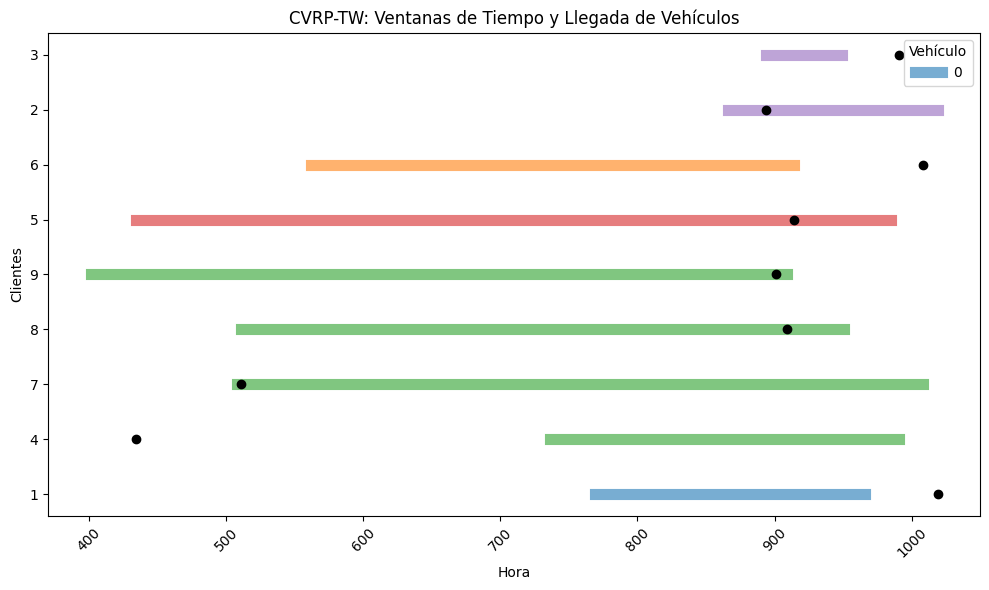

In [64]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

vehiculo_colors = {'0': 'tab:blue', '1': 'tab:green', '2': 'tab:red', '3': 'tab:orange', '4': 'tab:purple'}


for i, row in df.iterrows():
    ax.plot([row['VentanaInicio'], row['VentanaFin']], [i, i],
            color=vehiculo_colors[row['Vehiculo']], lw=8, alpha=0.6,
            label=row['Vehiculo'] if i == 0 else "")

    ax.plot(row['Llegada'], i, 'o', color='black')

ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['Cliente'])

plt.xticks(rotation=45)
plt.xlabel('Hora')
plt.ylabel('Clientes')
plt.title('CVRP-TW: Ventanas de Tiempo y Llegada de Vehículos')

ax.legend(title='Vehículo')
plt.tight_layout()
plt.show()

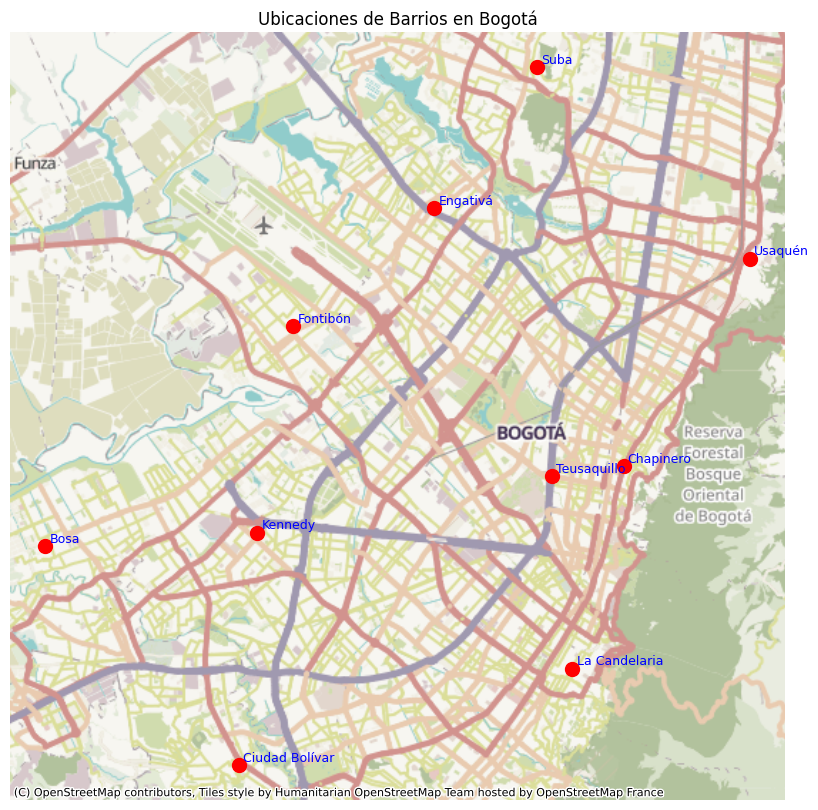

In [20]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# Datos de barrios con coordenadas de latitud y longitud
data = {
    "Barrio": ["Chapinero", "Usaquén", "Suba", "Engativá", "Fontibón", "Teusaquillo", "La Candelaria", "Kennedy", "Ciudad Bolívar", "Bosa"],
    "Latitud": [4.6451, 4.6950, 4.7410, 4.7071, 4.6787, 4.6427, 4.5965, 4.6292, 4.5734, 4.6259],
    "Longitud": [-74.0616, -74.0312, -74.0825, -74.1072, -74.1412, -74.0789, -74.0739, -74.1498, -74.1542, -74.2009]
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Convertir el DataFrame en un GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitud, df.Latitud))

# Establecer el sistema de referencia de coordenadas (CRS) al de WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)  # Convertir a Web Mercator para compatibilidad con contextily

# Graficar usando GeoPandas y Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=100)  # Aumentar el tamaño de los marcadores para mejor visualización
ctx.add_basemap(ax, crs=gdf.crs.to_string())  # Añadir mapa base usando el proveedor por defecto de contextily
ax.set_axis_off()  # Ocultar los ejes
plt.title('Ubicaciones de Barrios en Bogotá')
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["Barrio"]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='blue')


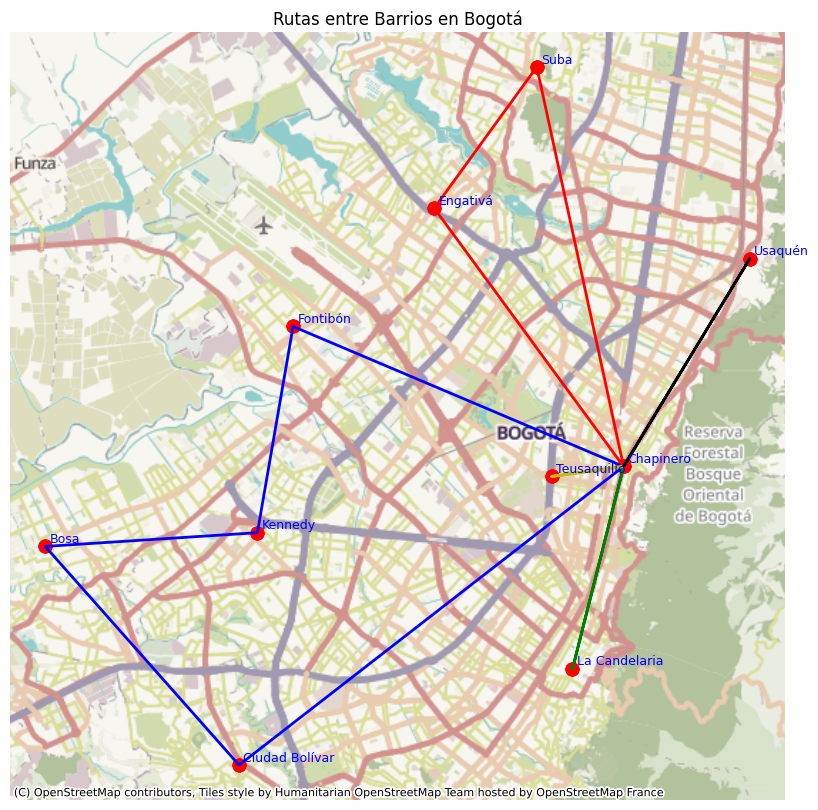

In [21]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString


data = {
    "Barrio": ["Chapinero", "Usaquén", "Suba", "Engativá", "Fontibón", "Teusaquillo", "La Candelaria", "Kennedy", "Ciudad Bolívar", "Bosa"],
    "Latitud": [4.6451, 4.6950, 4.7410, 4.7071, 4.6787, 4.6427, 4.5965, 4.6292, 4.5734, 4.6259],
    "Longitud": [-74.0616, -74.0312, -74.0825, -74.1072, -74.1412, -74.0789, -74.0739, -74.1498, -74.1542, -74.2009]
}

# Crear un DataFrame y luego un GeoDataFrame
df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitud, df.Latitud))
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)  # Convertir a Web Mercator


# Crear las líneas para estas rutas
lines = []
for route in vehicle_routes:
    points = [ gdf.geometry[i] for (i,j) in route ]
    points.append(gdf.geometry[route[0][0]])
    lines.append( LineString(points) )


colors = ['b', 'g', 'r', "y", "k"]
fig, ax = plt.subplots(figsize=(10, 10))

for i, linei in enumerate(lines):
  route_gdf = gpd.GeoDataFrame(geometry=[linei], crs=gdf.crs)

  gdf.plot(ax=ax, marker='o', color="red", markersize=80)  # Puntos
  route_gdf.plot(ax=ax, linewidth=2, color=colors[i])  # Rutas
  ctx.add_basemap(ax, crs=gdf.crs.to_string())  # Añadir mapa base
  ax.set_axis_off()

plt.title('Rutas entre Barrios en Bogotá')

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["Barrio"]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='blue')

plt.show()

In [22]:
pip install haversine

<ipython-input-30-dcd9a9691245>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 5)


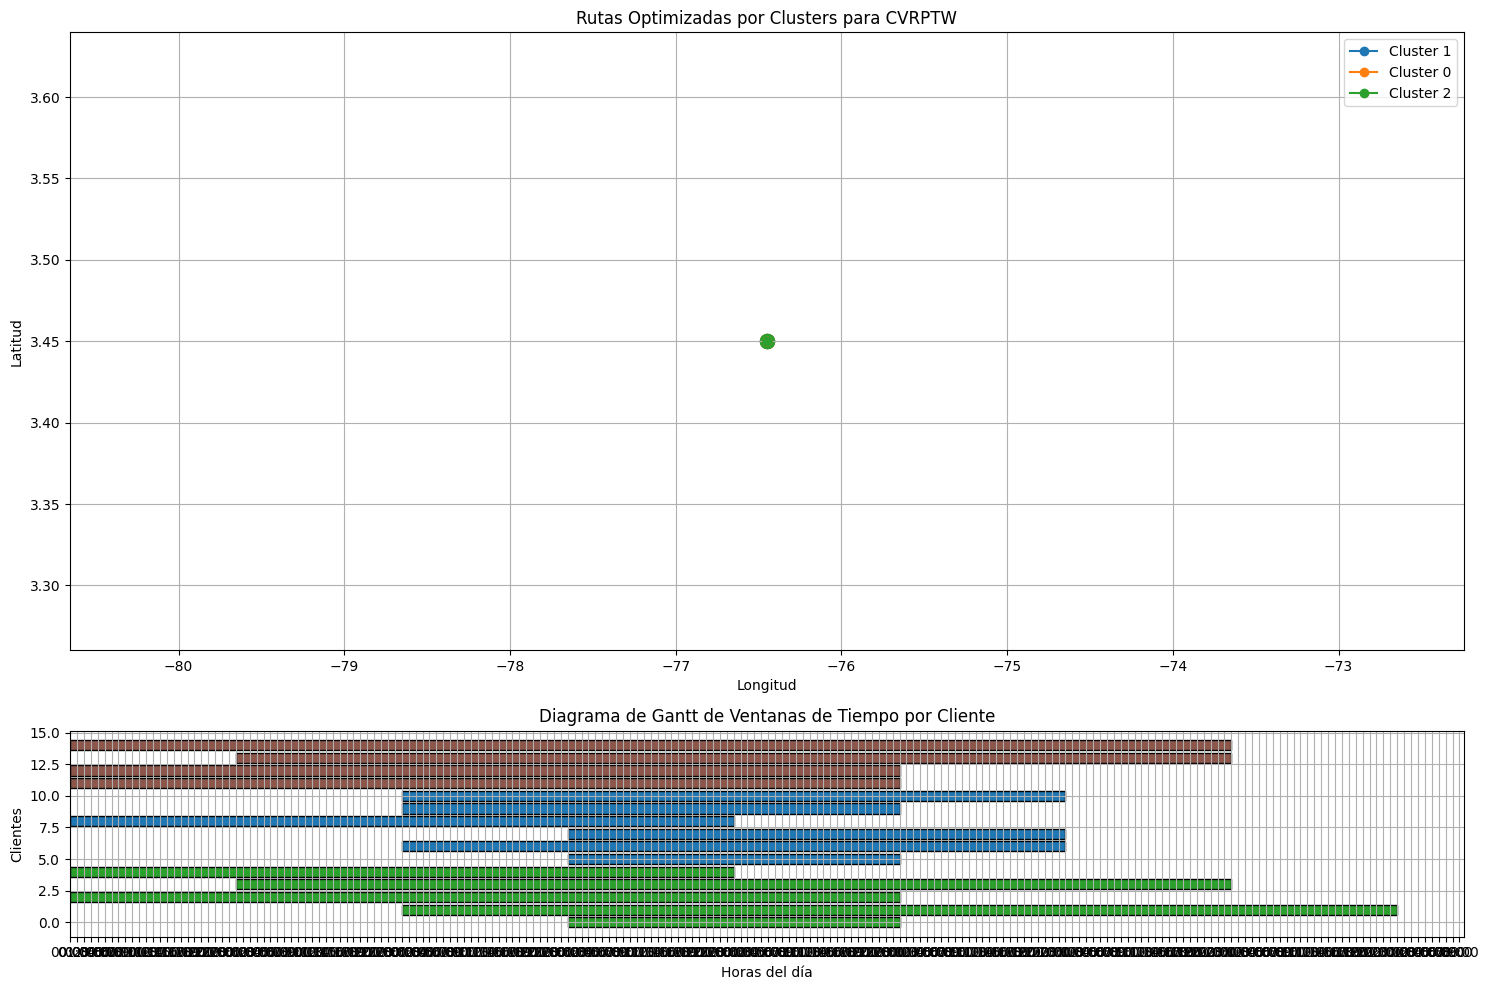

In [30]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Configuración inicial
np.random.seed(0)
n_clients = 15  # Reducido a 15 clientes
data = pd.DataFrame({
    'x': np.random.uniform(-76.5, -76.4, n_clients),
    'y': np.random.uniform(3.4, 3.5, n_clients),
    'earliest': np.random.randint(8, 12, n_clients),
    'latest': np.random.randint(12, 18, n_clients),
    'service_time': np.random.randint(5, 15, n_clients)  # Tiempo de servicio en minutos
})

# Posición del depósito
depot = {'x': -76.45, 'y': 3.45}

# Clustering con Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)  # Ajustado a 3 clusters
data['cluster'] = gmm.fit_predict(data[['x', 'y']])

# Heurística de inserción más cercana mejorada para respetar las ventanas de tiempo
def create_route_for_cluster(cluster_data):
    route = [depot] + [cluster_data.iloc[0]]
    cluster_data = cluster_data.iloc[1:].copy()
    current_time = route[1]['earliest']

    while not cluster_data.empty:
        last_customer = route[-1]
        cluster_data['distance_to_last'] = cluster_data.apply(
            lambda row: haversine((last_customer['y'], last_customer['x']), (row['y'], row['x']), unit=Unit.KILOMETERS), axis=1)
        feasible_next_customers = cluster_data[(cluster_data['earliest'] <= current_time + cluster_data['distance_to_last'] / 60 * 60) &
                                               (cluster_data['latest'] >= current_time + cluster_data['distance_to_last'] / 60 * 60)]
        if not feasible_next_customers.empty:
            next_customer = feasible_next_customers.sort_values(by=['distance_to_last', 'earliest']).iloc[0]
            current_time += next_customer['distance_to_last'] / 60 * 60 + last_customer['service_time']
            route.append(next_customer)
            cluster_data = cluster_data.drop(next_customer.name)
        else:
            break

    route.append(depot)
    return route

# Visualización de rutas y diagrama de Gantt
fig, ax = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
colors = plt.cm.get_cmap('tab10', 5)


for cluster in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster].sort_values(by='earliest')
    route = create_route_for_cluster(cluster_data)
    route_coords = np.array([(r['x'], r['y']) for r in route if isinstance(r, dict)])

    ax[0].plot(route_coords[:, 0], route_coords[:, 1], marker='o', linestyle='-', label=f'Cluster {cluster}')
    ax[0].scatter(route_coords[:, 0], route_coords[:, 1], s=100)

# Configuración del diagrama de Gantt
y_pos = 0
for cluster in data['cluster'].unique():  # Iterate over each cluster in the data
    cluster_data = data[data['cluster'] == cluster]
    for _, r in cluster_data.iterrows():  # Iterate over the clients in the cluster
        start_time = datetime.timedelta(hours=r['earliest'])
        end_time = datetime.timedelta(hours=r['latest'])
        ax[1].barh(y=y_pos, width=(end_time - start_time).total_seconds() / 3600,
                   left=start_time.total_seconds() / 3600, color=colors(cluster), edgecolor='black')
        y_pos += 1

ax[0].set_title('Rutas Optimizadas por Clusters para CVRPTW')
ax[0].set_xlabel('Longitud')
ax[0].set_ylabel('Latitud')
ax[0].legend()
ax[0].grid(True)

ax[1].set_title('Diagrama de Gantt de Ventanas de Tiempo por Cliente')
ax[1].set_xlabel('Horas del día')
ax[1].set_ylabel('Clientes')
ax[1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
data

,x,y,earliest,latest,service_time,cluster
0,-76.445119,3.457020,9,15,14,2
1,-76.428481,3.443860,10,15,12,0
2,-76.439724,3.498837,11,13,8,2
3,-76.445512,3.410204,10,17,7,1
4,-76.457635,3.420888,10,17,8,4
5,-76.435411,3.416131,11,12,14,1
6,-76.456241,3.465311,9,12,12,2
7,-76.410823,3.425329,8,13,12,1
8,-76.403634,3.446631,8,14,10,0
9,-76.461656,3.424443,8,12,6,4
